# data description
https://www.kaggle.com/datasets/mostafaabla/garbage-classification

- 12 classes
- 15,150 images
- some examples: ...

# data prep

- data augmentation: create more samples for minority classes
- `split-folders` load train/test dataset




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
!pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary #model summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install split-folders
import splitfolders
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
 %cd /content/drive/MyDrive/ComputerVision-Course/final-project/

/content/drive/MyDrive/ComputerVision-Course/final-project


# Data Prep

We will need to split the data into training and validation sets. For the training set, we will use transformer and weighted random sampling to augment the data and balance the classes.

In [6]:
# folder name: garbage_classification

# splitfolders.ratio('garbage_classification', output = 'output', seed = 2013,
#                    ratio = (0.8, 0.2), group_prefix = None, move = False)

In [7]:
transform_resnet = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225]),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.2),
                                    transforms.RandomRotation(degrees=(-20,20))])

In [8]:
train_data = datasets.ImageFolder('output/train', transform = transform_resnet)
test_data = datasets.ImageFolder('output/val', transform = transform_resnet)

In [9]:
train_loader = DataLoader(train_data, batch_size = 64, sampler = ImbalancedDatasetSampler(train_data),  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 64, shuffle=True,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(f'{len(class_names)} classes: {class_names}')
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

12 classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Training images available: 12409
Testing images available:  3106


In [10]:
for images,labels in train_loader:
    break
images.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([64, 3, 224, 224])

In [11]:
torch.unique(labels, return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 tensor([ 6,  4,  5,  7,  5,  4,  2, 11, 10,  2,  2,  6]))

Label: [ 7  5  8  3 11  8 10  7  1  4  1  2  3  2  4  7  8  2 11  4  8  0  0  3
  0  0  7  3  8 11  8  8  4  7  0  6 11  3  7  7  3  8  7  5  8  5  1  3
  2  1  7  2  7  0  7  6  9 11  5 11 10  9  8  4]
Class: paper green-glass plastic cardboard white-glass plastic trash paper biological clothes biological brown-glass cardboard brown-glass clothes paper plastic brown-glass white-glass clothes plastic battery battery cardboard battery battery paper cardboard plastic white-glass plastic plastic clothes paper battery metal white-glass cardboard paper paper cardboard plastic paper green-glass plastic green-glass biological cardboard brown-glass biological paper brown-glass paper battery paper metal shoes white-glass green-glass white-glass trash shoes plastic clothes


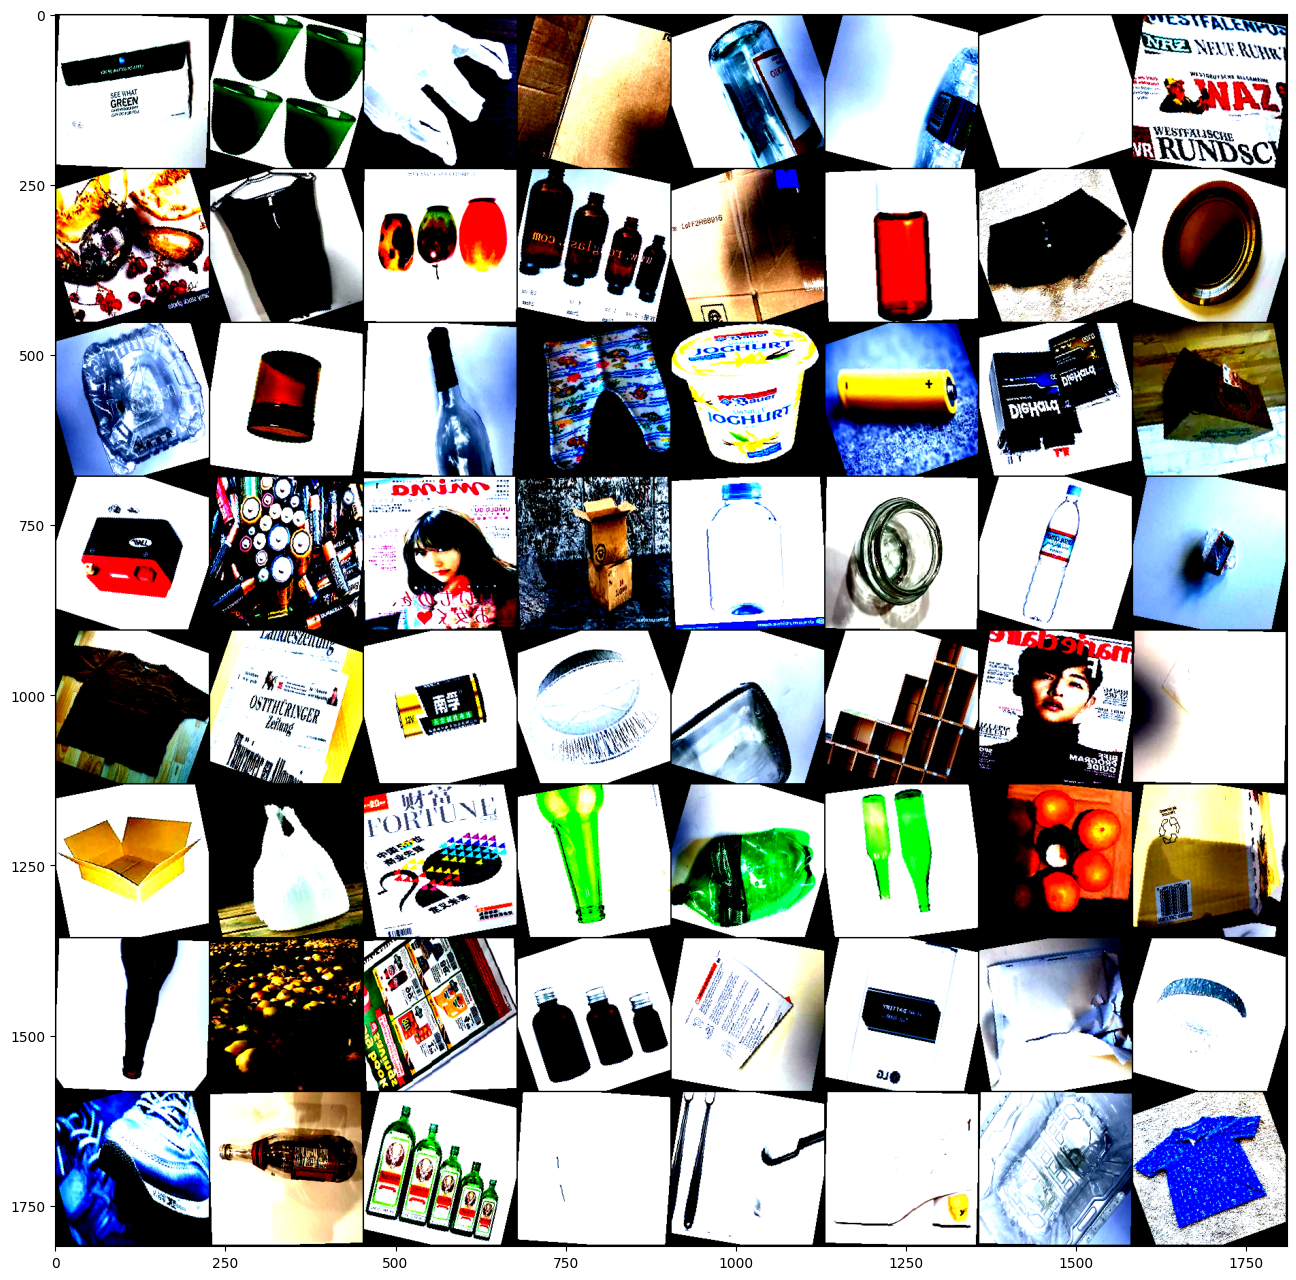

In [12]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=8)  # images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

# Model Building

In [21]:
num_classes = 12

resnet = torchvision.models.resnet50('ResNet50_Weights.DEFAULT')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [15]:
from torchsummary import summary
summary(resnet.to(device),(3,224,224)) #

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### unfreeze parameters

In [19]:
# resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

# change the final layer and add more layers
for param in resnet.layer4.parameters():
  param.required_grad = True

# for param in resnet.layer3.parameters():
#   param.required_grad = True

for param in resnet.avgpool.parameters():
  param.required_grad = True

resnet.to(device)

# change the final layers from resnet.fc = nn.Linear(2048,1000) to ...3 new FC

resnet.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.ReLU(),
    # nn.Linear(in_features=512, out_features=256, bias=False),
    # nn.ReLU(),
    # nn.Linear(in_features=256, out_features=128, bias=False),
    # nn.ReLU(),
    nn.Linear(in_features=128, out_features=12, bias=True)


)

lossfun = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam([
#                                           {"params": resnet.layer3.parameters(), "lr": 0.0001},
#                                           {"params": resnet.layer4.parameters(), "lr": 0.0001},
#                                           {"params": resnet.avgpool.parameters(), "lr": 0.0001},
#                                           {"params": resnet.fc[0].parameters(), "lr": 0.0001},
#                                           {"params": resnet.fc[2].parameters(), "lr": 0.001},
#                                           {"params": resnet.fc[4].parameters(), "lr": 0.001},
#                                           {"params": resnet.fc[6].parameters(), "lr": 0.001},
#                                           {"params": resnet.fc[8].parameters(), "lr": 0.001},
#                                            ],
#                                 lr=0.001, betas=(0.9, 0.999), weight_decay = 0.004)


optimizer = torch.optim.Adam(resnet.parameters(),lr = 0.001, weight_decay = 0.004)

### training

In [23]:
numepochs = 5

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  resnet.to(device)
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU

    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finished epoch 1/5. Test accuracy = 91.70%
Finished epoch 2/5. Test accuracy = 93.29%
Finished epoch 3/5. Test accuracy = 92.32%
Finished epoch 4/5. Test accuracy = 92.06%
Finished epoch 5/5. Test accuracy = 91.86%


In [ ]:
# numepochs = 5


# # initialize losses
# losses    = torch.zeros(numepochs)
# trainAcc  = []
# testAcc   = []


# # loop over epochs
# for epochi in range(numepochs):

#   # loop over training data batches
#   resnet.train() ## .train will backprop
#   batchAcc  = []
#   batchLoss = []
#   for X,y in train_loader:

#     X = X.to(device)
#     y = y.to(device)

#     # forward pass and loss
#     yHat = resnet(X)
#     loss = lossfun(yHat,y)

#     # backprop
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # loss from this batch
#     batchLoss.append(loss.item())

#     yHat = yHat.cpu()
#     y = y.cpu()

#     # compute accuracy
#     matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
#     matchesNumeric = matches.float()             # convert to numbers (0/1)
#     accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
#     batchAcc.append( accuracyPct )               # add to list of accuracies
#   # end of batch loop...

#   # now that we've trained through the batches, get their average training accuracy
#   trainAcc.append( np.mean(batchAcc) )

#   # and get average losses across the batches
#   losses[epochi] = np.mean(batchLoss)

#   # test accuracy
#   resnet.eval() ##.eval = not calculate gradient anymore
#   X,y = next(iter(test_loader)) # extract X,y from test dataloader

#     # New!
#   X = X.to(device) #to(device)
#   y = y.to(device) #to(device)

#   with torch.no_grad(): # deactivates autograd
#     yHat = resnet(X)

#   # New! bring outputs back
#   yHat = yHat.cpu()
#   y = y.cpu()

#   # compare the following really long line of code to the training accuracy lines
#   testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
#   if (epochi % 1) == 0:

#       print(f' epochs : {epochi}  loss : {loss : 2.2f}  trainAcc : {trainAcc[epochi]}  testAcc : {testAcc[epochi]}')
# # end epochs

## Save the Model

In [24]:
PATH = 'model_result/model_restnet'
torch.save(resnet.state_dict(), PATH)

## ResNet Performance Evaluation

In [25]:
def visualization(losses, trainAcc,testAcc, model_name):

  fig, ax = plt.subplots(1,2, figsize = (18,6)) # row = 1, col = 2

  # first plot: Training Loss v. Epochs
  ax[0].plot(losses, label = 'Train Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Training Loss')
  ax[0].legend(fontsize = 15)
  ax[0].set_title('Training Loss v. Epochs')

  # second plot: Training & Testing Accuracy v. Epochs
  ax[1].plot(trainAcc, label = 'Train accuracy')
  ax[1].plot(testAcc, label = 'Test accuracy') #test_accuracy starts from 100?
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  # print the latest accuracy [-1]
  ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%')
  ax[1].legend(fontsize = 15)

  plt.show()

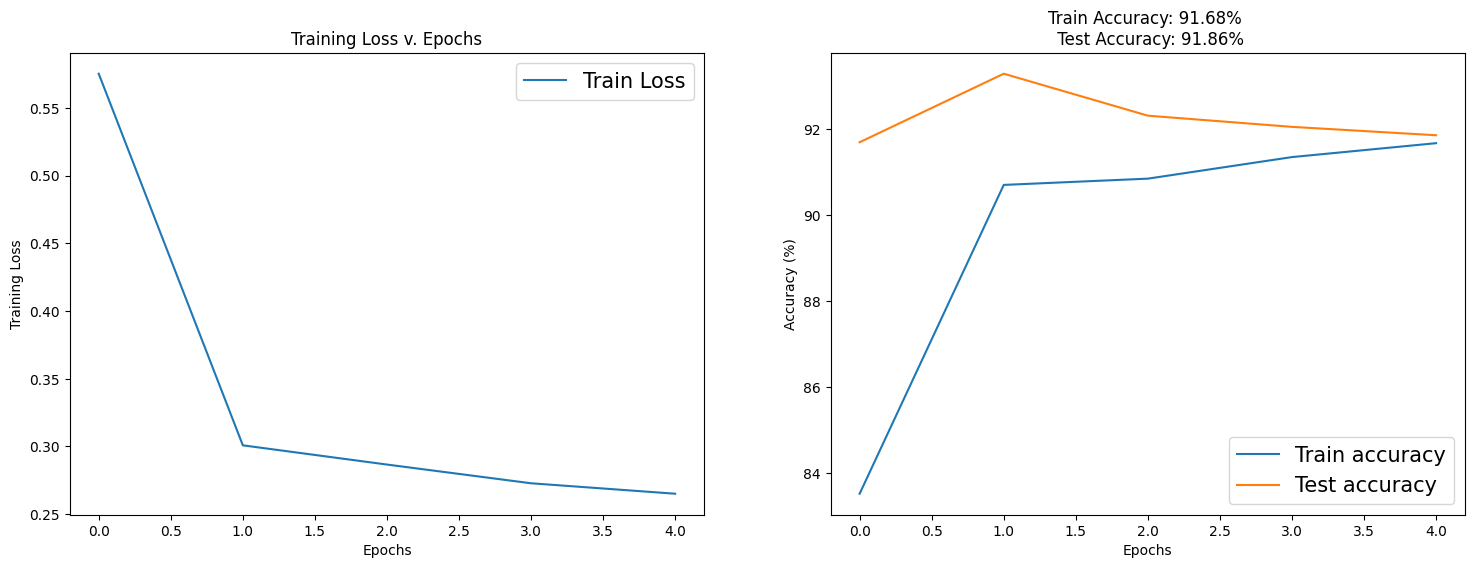

In [26]:
visualization(losses=trainLoss, trainAcc = trainAcc, testAcc = testAcc, model_name='model_restnet')